In [10]:
# train_networks: Training CNNs to be used by the main program

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import os
import imutils

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from skimage.morphology import watershed, disk
from skimage.feature import peak_local_max
from skimage.filters import meijering

from scipy import ndimage as ndi


def plot_two_images(imgL, imgR, titleL, titleR):
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(imgL, cmap='gray')
    plt.title(titleL)
    f.add_subplot(1,2, 2)
    plt.imshow(imgR, cmap='gray')
    plt.title(titleR)
    plt.show(block=True)

def highlight_labels(img, labels, value=255):
    image = img.copy()
    
    for r in range(image.shape[0]):
        for c in range(image.shape[1]):
            if image[r,c] in labels:
                image[r,c] = value
            else:
                image[r,c] = 0
                
    return image

def disk_erode(img, radius=24, iters=1):
    image = img.copy()
    kern_disk = disk(radius)
    eroded = cv2.erode(image, kern_disk, iterations=iters)
    
    return eroded

def get_markers(mask):
    eroded = np.zeros(mask.shape)
        
    labels = list(np.unique(mask))

    #drop background
    labels.remove(0)

    for label in labels:
        # extract each labeled cell mask separately
        high_mask = highlight_labels(mask, [label], value=label)

        #erode it with a disk structuring element
        temp_erod = disk_erode(high_mask)

        #add this label mask to the final combined mask
        eroded = np.add(eroded, temp_erod)
    
    return eroded

In [13]:
# Class for creating the CNN
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)        
        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)        
        self.conv7 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv8 = nn.Conv2d(256, 256, 3, padding=1)        
        self.conv9 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv10 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv11 = nn.Conv2d(768, 256, 3, padding=1)
        self.conv12 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv13 = nn.Conv2d(384, 128, 3, padding=1)
        self.conv14 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv15 = nn.Conv2d(192, 64, 3, padding=1)
        self.conv16 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv17 = nn.Conv2d(96, 32, 3, padding=1)
        self.conv18 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv_out = nn.Conv2d(32, 2, 1)
        
    def forward(self, x):
        """
        Forward pass through the network
        """
        x = F.relu(self.conv1(x))
        contraction_32 = F.relu(self.conv2(x))
        
        x = F.max_pool2d(contraction_32, kernel_size=2)
        x = F.relu(self.conv3(x))
        contraction_64 = F.relu(self.conv4(x))
        
        x = F.max_pool2d(contraction_64, kernel_size=2)
        x = F.relu(self.conv5(x))
        contraction_128 = F.relu(self.conv6(x))
        
        x = F.max_pool2d(contraction_128, kernel_size=2)
        x = F.relu(self.conv7(x))
        contraction_256 = F.relu(self.conv8(x))
        
        x = F.max_pool2d(contraction_256, kernel_size=2)
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        
        x = F.upsample(x, scale_factor=2, mode='bilinear')
        x = torch.cat(contraction_256, x)
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        
        x = F.upsample(x, scale_factor=2, mode='bilinear')
        x = torch.cat(contraction_128, x)
        x = F.relu(self.conv13(x))
        x = F.relu(self.conv14(x))
        
        x = F.upsample(x, scale_factor=2, mode='bilinear')
        x = torch.cat(contraction_64, x)
        x = F.relu(self.conv15(x))
        x = F.relu(self.conv16(x))
        
        x = F.upsample(x, scale_factor=2, mode='bilinear')
        x = torch.cat(contraction_32, x)
        x = F.relu(self.conv17(x))
        x = F.relu(self.conv18(x))
        
        x = self.conv_out(x)
        output = F.softmax(x, dim=0)
        return output


def lossFunction():
    """
    TODO: Implement the Weighted Mean Square Error loss function as per ISBI-final paper
    Currently using Mean Square Error loss
    """
    return F.mse_loss

def load_data(dataset):
    """
    Returns a list of dictionaries containing an image and the corresponding mask
    """
    data = []
    paths = [dataset + '/Sequence 1', dataset + '/Sequence 2']
    for path in paths:
        mask_path = path + ' Masks'
        for f in os.listdir(mask_path):
            if not f.endswith(".tif"):
                continue
            image = cv2.imread(os.path.join(path, f.replace('mask', '')), cv2.IMREAD_GRAYSCALE).astype(np.float32)
            mask = cv2.imread(os.path.join(mask_path, f), cv2.IMREAD_UNCHANGED)
            print("   Loaded " + os.path.join(mask_path, f) + ", " + os.path.join(path, f.replace('mask', '')))
            
            # Generate the Cell Mask and Markers from the Mask
            cell_mask = (mask > 0).astype(np.float32)
            markers = (get_markers(mask) > 0).astype(np.float32)
            
            # Pack the data for the DataLoader
            target = (np.array([cell_mask]), np.array([markers]))
            data.append((np.array([image]), target))
            
    return DataLoader(data, batch_size=9, shuffle=True)

def main():
    """
    Train 2 networks for predicting markers and the cell mask respectively
    Set trains on data from "Sequence 1 Masks" and "Sequence 2 Masks"
    and save the models
    """
    device = torch.device("cpu")
    
    # Net M predicts the markers. Net C predicts the cell mask
    net_m, net_c = Network().to(device), Network().to(device)
    
    criterion = lossFunction()
    
    # Optimising using Adam algorithm
    optimiser_m = optim.Adam(net_m.parameters(), lr=0.001)
    optimiser_c = optim.Adam(net_c.parameters(), lr=0.001)
    
    print("Loading Data...")
    trainLoader = load_data('DIC-C2DH-HeLa')
    print("Finished.")
    
    # Iterate over a number of epochs on the data
    for epoch in range(100):
        for i, batch in enumerate(trainLoader):
            x = batch[0]
            target = batch[1]
            cell_masks, markers = target # Unpack target data

            # Clear gradients from last step
            optimiser_m.zero_grad()
            optimiser_c.zero_grad()

            # Predict the markers from the image
            output_m = net_m(x)
            loss_m = criterion(output_m, markers)
            loss_m.backward()
            optimiser_m.step()
            
            # Predict the Cell Mask from the image
            output_c = net_c(x)
            loss_c = criterion(output_c, cell_masks)
            loss_c.backward()
            optimiser_c.step()

            if epoch == 0 or (epoch + 1) % 10 == 0:
                print(f"Epoch: {epoch+1}, Batch: {i + 1}")
                
                plt.imshow(np.array(x[0][0]), cmap='gray')
                plt.title("Input")
                plt.show()

                # Get the predicted Cell Mask and Markers for one of the images
                pred_c = (output_c[0][0].detach().numpy() > 0.5).astype(np.uint8)
                pred_m = (output_m[0][0].detach().numpy() > 0.5).astype(np.uint8)
                
                # Compare predicted to true images
                plot_two_images(pred_c, cell_masks[0][0].numpy(), "Predicted Cell Mask", "True Cell Mask")
                plot_two_images(pred_m, markers[0][0].numpy(), "Predicted Markers", "True Markers")

    torch.save(net_m.state_dict(), "./CNN_m.pth")
    torch.save(net_c.state_dict(), "./CNN_c.pth")
    print("Saved models.")

Loading Data...
   Loaded DIC-C2DH-HeLa/Sequence 1 Masks/t033mask.tif, DIC-C2DH-HeLa/Sequence 1/t033.tif
   Loaded DIC-C2DH-HeLa/Sequence 1 Masks/t039mask.tif, DIC-C2DH-HeLa/Sequence 1/t039.tif
   Loaded DIC-C2DH-HeLa/Sequence 1 Masks/t054mask.tif, DIC-C2DH-HeLa/Sequence 1/t054.tif
   Loaded DIC-C2DH-HeLa/Sequence 1 Masks/t034mask.tif, DIC-C2DH-HeLa/Sequence 1/t034.tif
   Loaded DIC-C2DH-HeLa/Sequence 1 Masks/t067mask.tif, DIC-C2DH-HeLa/Sequence 1/t067.tif
   Loaded DIC-C2DH-HeLa/Sequence 1 Masks/t021mask.tif, DIC-C2DH-HeLa/Sequence 1/t021.tif
   Loaded DIC-C2DH-HeLa/Sequence 1 Masks/t031mask.tif, DIC-C2DH-HeLa/Sequence 1/t031.tif
   Loaded DIC-C2DH-HeLa/Sequence 1 Masks/t002mask.tif, DIC-C2DH-HeLa/Sequence 1/t002.tif
   Loaded DIC-C2DH-HeLa/Sequence 1 Masks/t005mask.tif, DIC-C2DH-HeLa/Sequence 1/t005.tif
   Loaded DIC-C2DH-HeLa/Sequence 2 Masks/t006mask.tif, DIC-C2DH-HeLa/Sequence 2/t006.tif
   Loaded DIC-C2DH-HeLa/Sequence 2 Masks/t034mask.tif, DIC-C2DH-HeLa/Sequence 2/t034.tif
   Lo

/home/arc/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


Epoch: 1, Batch: 1


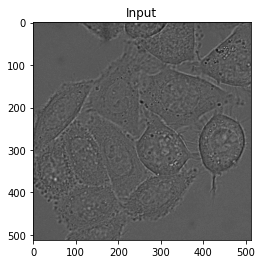

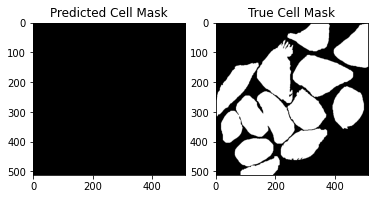

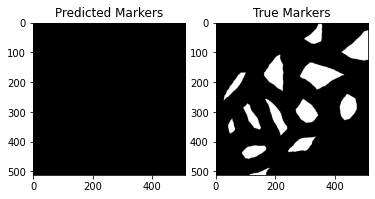

Epoch: 1, Batch: 2


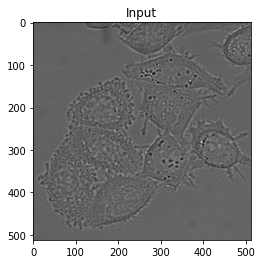

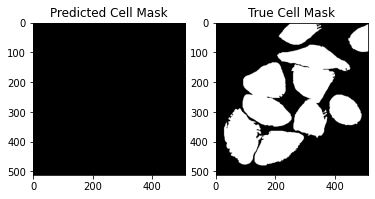

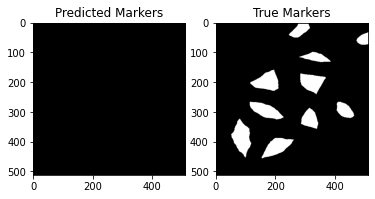

Epoch: 10, Batch: 1


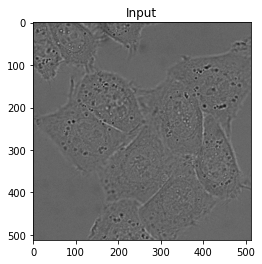

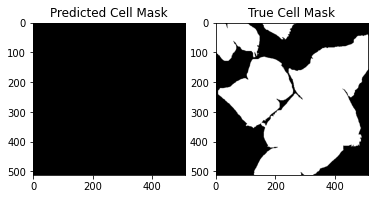

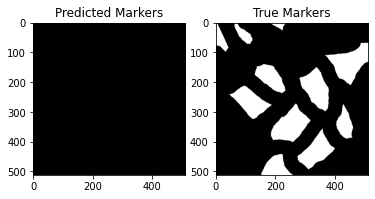

Epoch: 10, Batch: 2


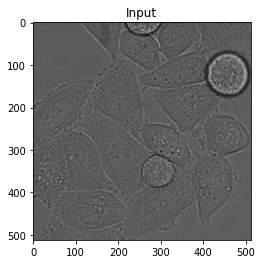

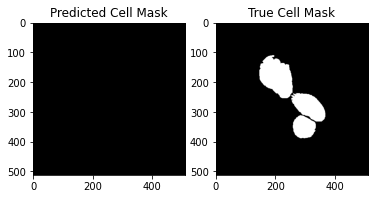

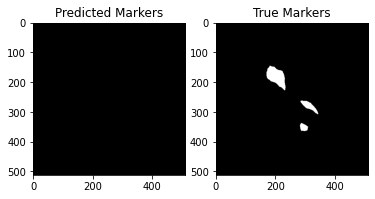

KeyboardInterrupt: 

In [14]:
if __name__ == '__main__':
    main()